In [1]:
! ls

argilla_df.parquet  sample_data


In [2]:
! git clone https://huggingface.co/openai-community/gpt2

Cloning into 'gpt2'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 87 (delta 17), reused 13 (delta 13), pack-reused 66 (from 1)
Unpacking objects: 100% (87/87), 1.65 MiB | 3.41 MiB/s, done.
Filtering content: 100% (11/11), 5.23 GiB | 55.70 MiB/s, done.


# **Загрузка модели**

In [3]:
import transformers
import torch

In [4]:
device = 'cuda'

In [5]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    'gpt2',
    torch_dtype=torch.float64,
)

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': "<|endoftext|>"})

1

# **Задание 1. LayerNorm vs RMSNorm**

для примера ниже нужно релизовать подсчет var и вычислить входной вектор в случае LayerNorm и RMSNorm



1) LayerNorm:

the paper: https://arxiv.org/abs/1607.06450




![](https://drive.google.com/uc?export=view&id=1rUfBxhGNGBw98EGWlCq7rOKYUEoyld2i)

2) RMSNorm:

the paper: https://arxiv.org/pdf/1910.07467v1.pdf


![](https://drive.google.com/uc?export=view&id=1s5Ed7ZRsZ1KvIT6Np-zSiBhckYc1NfWQ)

In [7]:
example = torch.Tensor([[1, 2, 3, 4, 5], [2, 3, 4, 5, 6]])

In [8]:
example

tensor([[1., 2., 3., 4., 5.],
        [2., 3., 4., 5., 6.]])

In [9]:
class LayerNorm:
  def __init__(self, eps: float = 1e-5):
    self.eps = eps

  def __call__(self, input: torch.Tensor):
    mean = (input.sum(axis=1) / input.shape[1]).reshape(-1, 1)
    print((input - mean) ** 2)
    var = (torch.sum((input - mean) ** 2, axis=1) / input.shape[1]).reshape(-1, 1)
    print(var)
    return (input - mean) / (torch.sqrt(var + self.eps))

In [10]:
layer_norm = LayerNorm()
result = layer_norm(example)
result

tensor([[4., 1., 0., 1., 4.],
        [4., 1., 0., 1., 4.]])
tensor([[2.],
        [2.]])


tensor([[-1.4142, -0.7071,  0.0000,  0.7071,  1.4142],
        [-1.4142, -0.7071,  0.0000,  0.7071,  1.4142]])

In [11]:
result[0][0]

tensor(-1.4142)

In [12]:
class RMSNorm:
  def __init__(self, eps: float = 1e-5):
    self.eps = eps

  def __call__(self, input: torch.Tensor):
    var = torch.var(input)
    return input / torch.sqrt(var + self.eps)

In [13]:
rms_norm = RMSNorm()
result = rms_norm(example)
result

tensor([[0.6325, 1.2649, 1.8974, 2.5298, 3.1623],
        [1.2649, 1.8974, 2.5298, 3.1623, 3.7947]])

In [14]:
result[0][0]

tensor(0.6325)

# Задание 2. Обучение модели.

1) необходимо подобрать такой lr, при котором лосс будет иметь тенденцию к снижению (скользящее срденее которого убывает)



In [15]:
import pandas as pd
from torch import nn
import transformers
import torch

In [16]:
sft_df = pd.read_parquet('argilla_df.parquet')

In [17]:
from torch.utils.data import Dataset, DataLoader, Sampler
from typing import Dict, Sequence, List, Iterator, Tuple

IGNORE_INDEX: int = -100
pad_token_id = 60000

def _tokenize_fn(text: str, max_length: int, tokenizer: transformers.PreTrainedTokenizer) -> List[int]:
    return tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        add_special_tokens=False,
    )['input_ids']

class SupervisedDataset(Dataset):
    """Dataset for supervised fine-tuning."""
    def __init__(self, dataset, tokenizer: transformers.PreTrainedTokenizer):
        super(SupervisedDataset, self).__init__()
        self.tokenizer = tokenizer

        bos_token = tokenizer.bos_token if tokenizer.bos_token is not None else ''
        self.sources = [f"{bos_token}{example[0]}" for example in dataset]
        self.targets = [f"{example[1]}{tokenizer.eos_token}" for example in dataset]

    def __len__(self) -> int:
        return len(self.sources)

    def padding(self, ids: torch.tensor, max_length: int) -> torch.tensor:
        return

    def __getitem__(self, i: int) -> Dict[str, List[int]]:
        source_ids = _tokenize_fn(self.sources[i], self.tokenizer.model_max_length, self.tokenizer)
        target_ids = _tokenize_fn(self.targets[i], self.tokenizer.model_max_length - len(source_ids), self.tokenizer)
        input_ids = torch.tensor(source_ids + target_ids)

        input_pad_len = self.tokenizer.model_max_length - len(input_ids)
        input_ids_pad = torch.tensor(source_ids + target_ids + [self.tokenizer.pad_token_id]*input_pad_len)
        input_att_mask = torch.tensor([[1]*len(input_ids) + [0]*input_pad_len])

        ### делаем сдвиг на 1, поскольку для последовательности 1, 2, 3, 4, 5
        ### таргетами будет последовательность, которую надо предсказать после n-токенов: 2,3,4,5,pad_token
        ### если вы используете библиотечную функцию train - в датасете сдвиг делать не нужно, его сделают во время train
        labels = torch.tensor([IGNORE_INDEX] * (len(source_ids) - 1) + target_ids + [pad_token_id]*(input_pad_len + 1))

        return dict(input_ids=input_ids_pad, input_att_mask=input_att_mask,
                    labels=labels)


In [18]:
tokenizer.pad_token_id

50256

In [19]:
train_batch = SupervisedDataset(
    dataset=sft_df[:200][['prompt', 'original_response']].values,
    tokenizer=tokenizer,
)

In [20]:
train_batch_loader = DataLoader(
    dataset=train_batch,
    batch_size=1,
    shuffle=False,
)

In [21]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr= 1e-5)
N_ITERATIONS = 100
cur_iteration = 0
loss_values = []
for x in train_batch_loader:
    if cur_iteration == N_ITERATIONS:
      break

    model.train()
    #################
    input_tokens = x['input_ids'].to(device)
    attention_mask = x['input_att_mask'].to(device)
    labels = x['labels'].clone().to(device)
    out_logits = model(input_ids=input_tokens, attention_mask=attention_mask).logits

    ### не затираем токены начала и конца, чтобы модель училась останавливаться ###
    labels[labels == pad_token_id] = -100

    loss_value = loss(out_logits.permute(0, 2, 1), labels)
    #################
    print(f"Loss value: {loss_value.item()}")
    loss_value.backward()
    optimizer.step()

    model.eval()
    cur_iteration += 1
    loss_values.append(loss_value.cpu().detach().numpy())

Loss value: 3.9249044199086724
Loss value: 3.220990455902605
Loss value: 0.8911405203400206
Loss value: 1.8348591082001304
Loss value: 3.2810972232425906
Loss value: 3.2623954559902444
Loss value: 3.2407610412763512
Loss value: 2.9124945949874927
Loss value: 2.9982373196828704
Loss value: 2.044439932162508
Loss value: 1.4910950813588264
Loss value: 3.684528984501194
Loss value: 0.4752830559634096
Loss value: 4.574996535758256
Loss value: 1.313060569574327
Loss value: 2.56733425683005
Loss value: 1.5710115502934257
Loss value: 2.813252872184948
Loss value: 3.4283651360469296
Loss value: 3.294562686187608
Loss value: 3.681605564683886
Loss value: 2.5936214553850325
Loss value: 1.3395890402513428
Loss value: 1.7914759446818322
Loss value: 5.73879251475878
Loss value: 8.946744079912158
Loss value: 2.1990817245529497
Loss value: 3.3216852574343814
Loss value: 3.826705352493775
Loss value: 3.763135347921063
Loss value: 2.170707262585545
Loss value: 1.716586457383057
Loss value: 2.87527682898


### 2) обратите внимание на то, как выглядит лосс

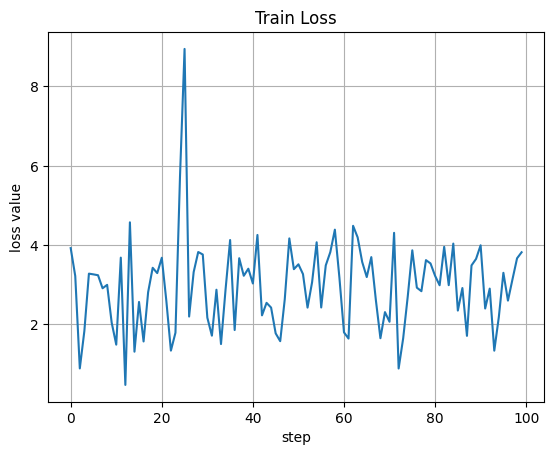

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = [i for i in range(len(loss_values))]
s = loss_values

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='step', ylabel='loss value',
       title='Train Loss')
ax.grid()

plt.show()

## 3) попробуйте явно прописать задание модели, то есть в качестве промпта задать: Тебе необходимо ответить на вопрос, приведенные ниже: ....

вставьте следующий текст перед самим вопросом: "You must answer the question correctly. Question: "

вставьте следующие текст между самим вопросом и правильным ответом на вопрос: "\n###answer: "

In [ ]:
from torch.utils.data import Dataset, DataLoader, Sampler
from typing import Dict, Sequence, List, Iterator, Tuple

IGNORE_INDEX: int = -100
pad_token_id = 60000

def _tokenize_fn(text: str, max_length: int, tokenizer: transformers.PreTrainedTokenizer) -> List[int]:
    return tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        add_special_tokens=False,
    )['input_ids']

class SupervisedDataset(Dataset):
    """Dataset for supervised fine-tuning."""
    def __init__(self, dataset, tokenizer: transformers.PreTrainedTokenizer):
        super(SupervisedDataset, self).__init__()
        self.tokenizer = tokenizer

        bos_token = tokenizer.bos_token if tokenizer.bos_token is not None else ''
        self.sources = [f"{bos_token} You must answer the question correctly. Question: {example[0]}" for example in dataset]
        self.targets = ["\n###answer: " + f"{example[1]}{tokenizer.eos_token}" for example in dataset]

    def __len__(self) -> int:
        return len(self.sources)

    def padding(self, ids: torch.tensor, max_length: int) -> torch.tensor:
        return

    def __getitem__(self, i: int) -> Dict[str, List[int]]:
        source_ids = _tokenize_fn(self.sources[i], self.tokenizer.model_max_length, self.tokenizer)
        target_ids = _tokenize_fn(self.targets[i], self.tokenizer.model_max_length - len(source_ids), self.tokenizer)
        input_ids = torch.tensor(source_ids + target_ids)

        input_pad_len = self.tokenizer.model_max_length - len(input_ids)
        input_ids_pad = torch.tensor(source_ids + target_ids + [self.tokenizer.pad_token_id]*input_pad_len)
        input_att_mask = torch.tensor([[1]*len(input_ids) + [0]*input_pad_len])

        labels = torch.tensor([IGNORE_INDEX] * (len(source_ids) - 1) + target_ids + [pad_token_id]*(input_pad_len + 1))

        return dict(input_ids=input_ids_pad, input_att_mask=input_att_mask,
                    labels=labels)


In [ ]:
### вставьте следующий текст перед самим вопросом: "You must answer the question correctly. Question: "
### вставьте следующие текст между самим вопросом и правильным ответом на вопрос: "\n###answer: "

In [ ]:
train_batch = SupervisedDataset(
    dataset=sft_df[:200][['prompt', 'original_response']].values,
    tokenizer=tokenizer,
)

In [ ]:
train_batch_loader = DataLoader(
    dataset=train_batch,
    batch_size=1,
    shuffle=False,
)

In [ ]:
for x in train_batch_loader:
    print(x)
    break

{'input_ids': tensor([[ 1639,  1276,  3280,  ..., 50256, 50256, 50256]]), 'input_att_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]]]), 'labels': tensor([[ -100,  -100,  -100,  ..., 60000, 60000, 60000]])}


In [ ]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    'gpt2',
    torch_dtype=torch.float64,
)

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
N_ITERATIONS = 100
cur_iteration = 0
loss_values = []
for x in train_batch_loader:
    if cur_iteration == N_ITERATIONS:
      break

    model.train()
    #################
    input_tokens = x['input_ids'].to(device)
    attention_mask = x['input_att_mask'].to(device)
    labels = x['labels'].clone().to(device)
    out_logits = model(input_ids=input_tokens, attention_mask=attention_mask).logits

    ### не затираем токены начала и конца, чтобы модель училась останавливаться ###
    labels[labels == pad_token_id] = -100

    loss_value = loss(out_logits.permute(0, 2, 1), labels)
    #################
    print(f"Loss value: {loss_value.item()}")
    loss_value.backward()
    optimizer.step()

    model.eval()
    cur_iteration += 1
    loss_values.append(loss_value.cpu().detach().numpy())

Loss value: 2.24248100064901
Loss value: 2.660657127969456
Loss value: 0.29960402274232395
Loss value: 0.7681532957418983
Loss value: 3.1315375414773743
Loss value: 2.9464519135725253
Loss value: 1.155810030460493
Loss value: 1.6212739881971179
Loss value: 2.7953048651384886
Loss value: 1.0722393085109652
Loss value: 0.902785947164193
Loss value: 2.7763502550764207
Loss value: 0.42230220518713335
Loss value: 4.096564417550312
Loss value: 1.0263901547847403
Loss value: 1.374801844540966
Loss value: 1.0161914003071675
Loss value: 1.626075080674178
Loss value: 2.343232980411125
Loss value: 2.9411741379444085
Loss value: 3.2400133307515486
Loss value: 2.2607476317718596
Loss value: 1.2922413522815814
Loss value: 1.279505358767061
Loss value: 3.659752985902492
Loss value: 2.1828843479730664
Loss value: 2.1858455065079507
Loss value: 3.342965263505418
Loss value: 3.6954562265566424
Loss value: 3.66696922404828
Loss value: 1.8590421777510753
Loss value: 1.8133300148350793
Loss value: 2.563920

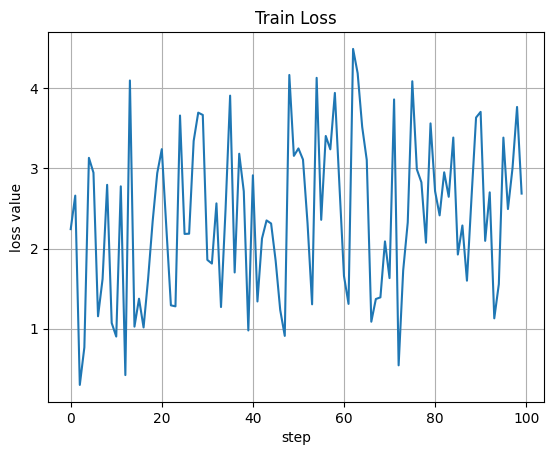

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = [i for i in range(len(loss_values))]
s = loss_values

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='step', ylabel='loss value',
       title='Train Loss')
ax.grid()

plt.show()